In [1]:
## Standard libraries
import os
import numpy as np
from PIL import Image
from typing import Any
from collections import defaultdict
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0


## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
import torchvision
from torchvision import transforms

/tmp/ipykernel_1577753/268212526.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
import os
import sys
import jax
import zipfile
import jax.numpy as jnp
import optax
import torch
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as T
import pandas as pd
import numpy as np
import argparse

from jax.example_libraries import optimizers
from sklearn.metrics import average_precision_score
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils import data
from urllib import request
from typing import Tuple
from torch.utils.data import Dataset
from flax.struct import dataclass
from jax.tree_util import tree_map
from evojax.task.base import VectorizedTask
from evojax.task.base import TaskState

In [3]:
print("Device:", jax.devices())

Device: [gpu(id=0), gpu(id=1)]


In [6]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = './data/'
CHECKPOINT_PATH = "./notebook_output/saved_models/DenseNet/196/default/"

In [41]:
os.path.join(CHECKPOINT_PATH, 'checkpoint')

'./notebook_output/saved_models/DenseNet/196/default/checkpoint'

In [7]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class ChexpertSmall(Dataset):
    url = 'http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip'
    dir_name = os.path.splitext(os.path.basename(url))[0]  # folder to match the filename
    attr_all_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                      'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                      'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
                      'Fracture', 'Support Devices']
    # select only the competition labels
    attr_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

    def __init__(self, root, mode='train', transform=None, data_filter=None, mini_data=None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        assert mode in ['train', 'valid', 'test']
        self.mode = mode

        # if mode is test; root is path to csv file (in test mode), construct dataset from this csv;
        # if mode is train/valid; root is path to data folder with `train`/`valid` csv file to construct dataset.
        if mode == 'test':
            self.data = pd.read_csv(self.root, keep_default_na=True)
            self.root = '.'  # base path; to be joined to filename in csv file in __getitem__
            self.data[self.attr_names] = pd.DataFrame(np.zeros((len(self.data), len(self.attr_names))))  # attr is vector of 0s under test
        else:
            self._maybe_download_and_extract()
            self._maybe_process(data_filter)

            data_file = os.path.join(self.root, self.dir_name, 'valid.pt' if mode in ['valid', 'vis'] else 'train.pt')
            self.data = torch.load(data_file)

        # store index of the selected attributes in the columns of the data for faster indexing
        self.attr_idxs = [self.data.columns.tolist().index(a) for a in self.attr_names]

    def __getitem__(self, idx):
        # 1. select and load image
        img_path = self.data.iloc[idx, 0]  # 'Path' column is 0
        img = Image.open(os.path.join(self.root, img_path))
        if self.transform is not None:
            img = self.transform(img)

        # 2. select attributes as targets
        attr = self.data.iloc[idx, self.attr_idxs].values.astype(np.float32)
        attr = torch.from_numpy(attr)

        # 3. save index for extracting the patient_id in prediction/eval results as 'CheXpert-v1.0-small/valid/patient64541/study1'
        #    performed using the extract_patient_ids function
        idx = self.data.index[idx]  # idx is based on len(self.data); if we are taking a subset of the data, idx will be relative to len(subset);
                                    # self.data.index(idx) pulls the index in the original dataframe and not the subset

        return img, attr, idx

    def __len__(self):
        return len(self.data)

    def _maybe_download_and_extract(self):
        fpath = os.path.join(self.root, os.path.basename(self.url))
        print('fpath : ', fpath)
        # if data dir does not exist, download file to root and unzip into dir_name
        if not os.path.exists(os.path.join(self.root, self.dir_name)):
            # check if zip file already downloaded
            if not os.path.exists(os.path.join(self.root, os.path.basename(self.url))):
                print('Downloading ' + self.url + ' to ' + fpath)
                def _progress(count, block_size, total_size):
                    sys.stdout.write('\r>> Downloading %s %.1f%%' % (fpath,
                        float(count * block_size) / float(total_size) * 100.0))
                    sys.stdout.flush()
                request.urlretrieve(self.url, fpath, _progress)
                print()
            print('Extracting ' + fpath)
            with zipfile.ZipFile(fpath, 'r') as z:
                z.extractall(self.root)
                if os.path.exists(os.path.join(self.root, self.dir_name, '__MACOSX')):
                    os.rmdir(os.path.joinb(self.root, self.dir_name, '__MACOSX'))
            os.unlink(fpath)
            print('Dataset extracted.')

    def _maybe_process(self, data_filter):
        # Dataset labels are: blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive.
        # Process by:
        #    1. fill NAs (blanks for unmentioned) as 0 (negatives)
        #    2. fill -1 as 1 (U-Ones method described in paper)  # TODO -- setup options for uncertain labels
        #    3. apply attr filters as a dictionary {data_attribute: value_to_keep} e.g. {'Frontal/Lateral': 'Frontal'}

        # check for processed .pt files
        train_file = os.path.join(self.root, self.dir_name, 'train.pt')
        valid_file = os.path.join(self.root, self.dir_name, 'valid.pt')
        if not (os.path.exists(train_file) and os.path.exists(valid_file)):
            # load data and preprocess training data
            valid_df = pd.read_csv(os.path.join(self.root, self.dir_name, 'valid.csv'), keep_default_na=True)
            train_df = self._load_and_preprocess_training_data(os.path.join(self.root, self.dir_name, 'train.csv'), data_filter)

            # save
            torch.save(train_df, train_file)
            torch.save(valid_df, valid_file)

    def _load_and_preprocess_training_data(self, csv_path, data_filter):
        train_df = pd.read_csv(csv_path, keep_default_na=True)

        # 1. fill NAs (blanks for unmentioned) as 0 (negatives)
        # attr columns ['No Finding', ..., 'Support Devices']; note AP/PA remains with NAs for Lateral pictures
        train_df[self.attr_names] = train_df[self.attr_names].fillna(0)

        # 2. fill -1 as 1 (U-Ones method described in paper)  # TODO -- setup options for uncertain labels
        train_df[self.attr_names] = train_df[self.attr_names].replace(-1,1)

        if data_filter is not None:
            # 3. apply attr filters
            # only keep data matching the attribute e.g. df['Frontal/Lateral']=='Frontal'
            for k, v in data_filter.items():
                train_df = train_df[train_df[k]==v]

            with open(os.path.join(os.path.dirname(csv_path), 'processed_training_data_filters.json'), 'w') as f:
                json.dump(data_filter, f)

        return train_df

def fetch_dataloader(args, mode):
    assert mode in ['train', 'valid']

    transforms = T.Compose([
        T.Resize(args.resize) if args.resize else T.Lambda(lambda x: x),
        T.CenterCrop(320 if not args.resize else args.resize),
        lambda x: torch.from_numpy(np.array(x, copy=True)).float().div(255).unsqueeze(0),
        T.Normalize(mean=[0.5330], std=[0.0349]),
        lambda x: x.expand(3, -1, -1),
        T.Lambda(lambda x: x.permute(1, 2, 0))  # Permute dimensions to change to channels last format
    ])

    dataset = ChexpertSmall(args.data_path, mode, transforms, mini_data=args.mini_data)

    return DataLoader(dataset, args.batch_size, collate_fn=numpy_collate, shuffle=(mode=='train'), pin_memory=(args.device.type=='cuda'),
                       num_workers=0 if mode=='valid' else 16) # since evaluating the valid_dataloader is called inside the
                                                              # train_dataloader loop, 0 workers for valid_dataloader avoids
                                                              # forking (cf torch dataloader docs); else memory sharing gets clunky


In [8]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--pop-size', type=int, default=32, help='NE population size.')
    parser.add_argument('--batch-size', type=int, default=8, help='Batch size for training.')  # Adjusted for CheXpert
    parser.add_argument('--data_path', default='./data', help='Location of train/valid datasets directory or path to test csv file.')
    parser.add_argument('--max-iter', type=int, default=1000, help='Max training iterations.')  # Adjust as needed
    parser.add_argument('--test-interval', type=int, default=100, help='Test interval.')
    parser.add_argument('--resize', type=int, help='Size of minimum edge to which to resize images.')
    parser.add_argument('--log-interval', type=int, default=10, help='Logging interval.')
    parser.add_argument('--restore', type=str, help='Path to a single model checkpoint to restore or folder of checkpoints to ensemble.')
    parser.add_argument('--seed', type=int, default=42, help='Random seed for training.')
    parser.add_argument('--center-lr', type=float, default=0.006, help='Center learning rate.')  # Adjust as needed
    parser.add_argument('--mini_data', type=int, help='Truncate dataset to this number of examples.')
    parser.add_argument('--std-lr', type=float, default=0.089, help='Std learning rate.')  # Adjust as needed
    parser.add_argument('--init-std', type=float, default=0.039, help='Initial std.')  # Adjust as needed
    parser.add_argument('--cuda', type=int, help='Which cuda device to use.')
    parser.add_argument('--gpu-id', type=str, help='GPU(s) to use.')
    parser.add_argument('--debug', action='store_true', help='Debug mode.')
    config, _ = parser.parse_known_args()
    return config

args = parse_args()

In [9]:
args.data_path=DATASET_PATH

In [10]:
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
train_loader = fetch_dataloader(args, mode='train')

for images, labels, idx in train_loader:
            # Print the shape of images and labels
            print("Shape of train images:", images.shape)
            print("Shape of train labels:", labels.shape)
            # Optionally, break after the first batch to avoid printing shapes for all batches
            break

fpath :  ./data/CheXpert-v1.0-small.zip
Shape of train images: (8, 320, 320, 3)
Shape of train labels: (8, 5)


In [25]:
val_loader = fetch_dataloader(args, mode='valid')
 
for images, labels, idx in val_loader:
            # Print the shape of images and labels
            print("valid labels:", labels)
            break
    

fpath :  ./data/CheXpert-v1.0-small.zip
valid labels: [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [13]:
pathologies = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# Initialize counters
counters = {pathology: {'0': 0, '1': 0} for pathology in pathologies}

# Iterate over the dataloader
for _, labels,_ in val_loader:
    # Assuming labels are in shape (batch_size, num_pathologies)
    # Count 0's and 1's
    for i, pathology in enumerate(pathologies):
        counters[pathology]['0'] += np.sum(labels[:, i] == 0).item()
        counters[pathology]['1'] += np.sum(labels[:, i] == 1).item()

# Print results
for pathology in pathologies:
    print(f"{pathology}: 0's = {counters[pathology]['0']}, 1's = {counters[pathology]['1']}")

Atelectasis: 0's = 154, 1's = 80
Cardiomegaly: 0's = 166, 1's = 68
Consolidation: 0's = 201, 1's = 33
Edema: 0's = 189, 1's = 45
Pleural Effusion: 0's = 167, 1's = 67


In [18]:
imgs, labels, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(axis=(0,1,2)))
print("Batch std", imgs.std(axis=(0,1,2)))

Batch mean [-0.04963209 -0.04963209 -0.04963209]
Batch std [8.231819 8.231819 8.231819]


In [16]:
imgs, labels, _ = next(iter(val_loader))
print("Batch mean", imgs.mean(axis=(0,1,2)))
print("Batch std", imgs.std(axis=(0,1,2)))

Batch mean [-0.2843178 -0.2843178 -0.2843178]
Batch std [8.26009 8.26009 8.26009]


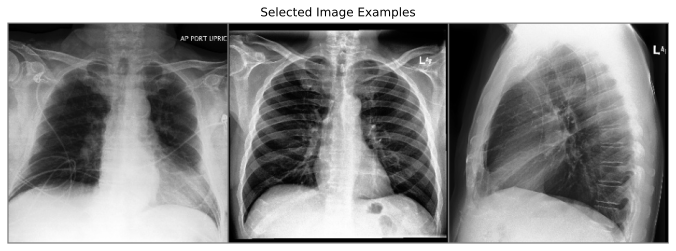

In [26]:


NUM_IMAGES = 3  # Selecting 3 images

# Assuming train_dataset is your dataset with shape [32, 320, 320, 3]
# Convert images to PyTorch tensors and rearrange dimensions from [H, W, C] to [C, H, W]
images_torch = [torch.tensor(images[idx]).permute(2, 0, 1) for idx in range(NUM_IMAGES)]

# Stacking the images
imgs_stack = torch.stack(images_torch, axis=0)

# Creating a grid of images, 3 in a row
img_grid = torchvision.utils.make_grid(imgs_stack, nrow=3, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)  # Adjusting dimensions for plotting

# Plotting
plt.figure(figsize=(12, 4))  # Adjust the size as needed
plt.title("Selected Image Examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


In [27]:
images.shape

(8, 320, 320, 3)

In [28]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include batch statistics
    batch_stats: Any

In [63]:
class TrainerModule:

    def __init__(self,
                 model_name : str,
                 model_class : nn.Module,
                 model_hparams : dict,
                 optimizer_name : str,
                 optimizer_hparams : dict,
                 exmp_imgs : Any,
                 seed=42):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            model_name - String of the class name, used for logging and saving
            model_class - Class implementing the neural network
            model_hparams - Hyperparameters of the model, used as input to model constructor
            optimizer_name - String of the optimizer name, supporting ['sgd', 'adam', 'adamw']
            optimizer_hparams - Hyperparameters of the optimizer, including learning rate as 'lr'
            exmp_imgs - Example imgs, used as input to initialize the model
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.model_name = model_name
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = self.model_class(**self.model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        self.exmp_imgs = exmp_imgs
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        
        def calculate_loss(params, batch_stats, batch, train):
            imgs, labels, idx = batch
            # Run model. During training, we need to update the BatchNorm statistics.
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                    imgs,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)
            logits, new_model_state = outs if train else (outs, None)

            # Use binary cross-entropy loss for multi-label classification
            loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()

            # Calculate accuracy; may need to be adjusted based on the specific requirements
            # For multi-label tasks, accuracy is often calculated differently, such as per-label accuracy
            # Here is a simple threshold-based approach
            predicted_labels = logits > 0.5  # using 0.5 as threshold
            acc = (predicted_labels == labels).mean()

            return loss, (acc, new_model_state, logits)


        # Training function
        def train_step(state, batch):
            loss_fn = lambda params: calculate_loss(params, state.batch_stats, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, new_model_state, logits = ret[0], ret[1][0], ret[1][1], ret[1][2]
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
            return state, loss, acc, logits
        # Eval function
        def eval_step(state, batch):
            # Return the accuracy for a single batch
            _, (acc, _, logits) = calculate_loss(state.params, state.batch_stats, batch, train=False)
            return acc, logits
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        init_rng = jax.random.PRNGKey(self.seed)
        variables = self.model.init(init_rng, exmp_imgs, train=True)
        self.init_params, self.init_batch_stats = variables['params'], variables['batch_stats']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # Initialize learning rate schedule and optimizer
        if self.optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif self.optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif self.optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer "{opt_class}"'
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        total_steps = 50*(27927) + 50
        lr_schedule = optax.piecewise_constant_schedule(init_value=self.optimizer_hparams.pop('lr'),
                                                               boundaries_and_scales={int(total_steps*0.1):0.8,
                                                                                      int(total_steps*0.2):0.8,
                                                                                      int(total_steps*0.4):0.5})
        # Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip(1.0)]
        if opt_class == optax.sgd and 'weight_decay' in self.optimizer_hparams:  # wd is integrated in adamw
            transf.append(optax.add_decayed_weights(self.optimizer_hparams.pop('weight_decay')))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **self.optimizer_hparams)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       batch_stats=self.init_batch_stats if self.state is None else self.state.batch_stats,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        if self.state is None:
            self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        pathologies = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                print('eval acc : ',eval_acc)
                for i, pathology in enumerate(pathologies):
                    self.logger.add_scalar(f'val/auc_pr_{pathology}', eval_acc[i], global_step=epoch_idx)
                #if eval_acc >= best_eval:
                    #best_eval = eval_acc
                    #print('best eval : ', best_eval)
                #self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        all_logits, all_labels = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss, acc, logits = self.train_step(self.state, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
            all_logits.append(jax.device_get(logits))
            all_labels.append(jax.device_get(batch[1]))
        # Calculate average loss and accuracy
        avg_loss = np.mean(jax.device_get(metrics['loss']))
        avg_acc = np.mean(jax.device_get(metrics['acc']))
        print(f'Epoch {epoch} - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}')

        # Reshape logits and labels for AUC-PR calculation
        all_logits = np.concatenate(all_logits, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Calculate AUC-PR for each label
        auc_pr_scores = [average_precision_score(all_labels[:, i], all_logits[:, i]) for i in range(all_labels.shape[1])]
        avg_auc_pr = np.mean(auc_pr_scores)
        
        self.logger.add_scalar('train/', auc_pr_scores, global_step=epoch)
        print(f'Epoch {epoch} - Avg AUC-PR: {avg_auc_pr:.4f}')
    
    def train_epoch(self, train_loader, epoch):
        metrics = defaultdict(list)
        all_logits, all_labels = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss, acc, logits = self.train_step(self.state, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
            all_logits.append(jax.device_get(logits))
            all_labels.append(jax.device_get(batch[1]))
    
        # Calculate average loss and accuracy
        avg_loss = np.mean(jax.device_get(metrics['loss']))
        avg_acc = np.mean(jax.device_get(metrics['acc']))
        print(f'Epoch {epoch} - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}')
    
        # Reshape logits and labels for AUC-PR calculation
        all_logits = np.concatenate(all_logits, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
    
        # Calculate and print AUC-PR for each pathology
        pathologies = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
        for i, pathology in enumerate(pathologies):
            auc_pr = average_precision_score(all_labels[:, i], all_logits[:, i])
            print(f'Epoch {epoch} - AUC-PR for {pathology}: {auc_pr:.4f}')
            self.logger.add_scalar('train/'+pathology, auc_pr, global_step=epoch)

    def eval_model(self, data_loader):
        all_logits, all_labels = [], []
        for batch in data_loader:
            _, logits = self.eval_step(self.state, batch)
            all_logits.append(jax.device_get(logits))
            all_labels.append(jax.device_get(batch[1]))
    
        # Reshape logits and labels for AUC-PR calculation
        all_logits = np.concatenate(all_logits, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
    
        # Calculate and print AUC-PR for each pathology
        pathologies = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
        auc_pr_scores = []
        for i, pathology in enumerate(pathologies):
            auc_pr = average_precision_score(all_labels[:, i], all_logits[:, i])
            auc_pr_scores.append(auc_pr)
            print(f'AUC-PR for {pathology}: {auc_pr:.4f}')
    
        # Optionally, return the AUC-PR scores if needed
        return auc_pr_scores

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target={'params': self.state.params,
                                            'batch_stats': self.state.batch_stats},
                                    step=step,
                                   overwrite=True)

    def load_model(self, pretrained=False, num_classes=None):
        # Initialize a new model if the number of classes is different
        if num_classes is not None:
            self.model = self.model_class(num_classes=num_classes, **{k: v for k, v in self.model_hparams.items() if k != 'num_classes'})
    
        # Load model state
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, 'checkpoint'), target=None)
    
        # Initialize the new model to get its initial parameters and batch_stats
        init_rng = jax.random.PRNGKey(self.seed)
        dummy_input = jnp.ones((1, *self.exmp_imgs.shape[1:]))  # Adjust the input shape as necessary
        init_state = self.model.init(init_rng, dummy_input, train=True)
        new_model_params = init_state['params']
        new_batch_stats = init_state.get('batch_stats', None)
    
        # Transfer all weights except for the final Dense layer ('Dense_0')
        transferred_params = {name: state_dict['params'][name] for name in new_model_params.keys() if 'Dense_0' not in name}
        if num_classes is not None:
            transferred_params['Dense_0'] = new_model_params['Dense_0']
    
        # Use the batch stats from the checkpoint if available
        batch_stats = state_dict.get('batch_stats', new_batch_stats)
    
        self.state = TrainState.create(
            apply_fn=self.model.apply,
            params=transferred_params,
            batch_stats=batch_stats,
            tx=optax.sgd(0.1)  # Default optimizer; this will be overwritten in init_optimizer
        )
            
    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, 'checkpoint'))

In [51]:
def train_classifier(*args, num_epochs=200, **kwargs):
    num_classes_for_new_task = 5
    # Initialize the trainer
    trainer = TrainerModule(*args, **kwargs)

    # Load model (pretrained or start from scratch)
    if trainer.checkpoint_exists():
        trainer.load_model(pretrained=True,num_classes=num_classes_for_new_task)
    else:
        trainer.load_model(pretrained=False,num_classes=num_classes_for_new_task)

    # Train the model
    trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)

    # Test the trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

In [38]:
def train_classifier(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

In [31]:
densenet_kernel_init = nn.initializers.kaiming_normal()

class DenseLayer(nn.Module):
    bn_size : int  # Bottleneck size (factor of growth rate) for the output of the 1x1 convolution
    growth_rate : int  # Number of output channels of the 3x3 convolution
    act_fn : callable  # Activation function

    @nn.compact
    def __call__(self, x, train=True):
        z = nn.BatchNorm()(x, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.bn_size * self.growth_rate,
                    kernel_size=(1, 1),
                    kernel_init=densenet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.growth_rate,
                    kernel_size=(3, 3),
                    kernel_init=densenet_kernel_init,
                    use_bias=False)(z)
        x_out = jnp.concatenate([x, z], axis=-1)
        return x_out

In [32]:
class DenseBlock(nn.Module):
    num_layers : int  # Number of dense layers to apply in the block
    bn_size : int  # Bottleneck size to use in the dense layers
    growth_rate : int  # Growth rate to use in the dense layers
    act_fn : callable  # Activation function to use in the dense layers

    @nn.compact
    def __call__(self, x, train=True):
        for _ in range(self.num_layers):
            x = DenseLayer(bn_size=self.bn_size,
                           growth_rate=self.growth_rate,
                           act_fn=self.act_fn)(x, train=train)
        return x

In [33]:
class TransitionLayer(nn.Module):
    c_out : int  # Output feature size
    act_fn : callable  # Activation function

    @nn.compact
    def __call__(self, x, train=True):
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = nn.Conv(self.c_out,
                    kernel_size=(1, 1),
                    kernel_init=densenet_kernel_init,
                    use_bias=False)(x)
        x = nn.avg_pool(x, (2, 2), strides=(2, 2))
        return x

In [48]:
class DenseNet(nn.Module):
    num_classes : int
    act_fn : callable = nn.relu
    num_layers : tuple = (6, 12, 24, 16)
    bn_size : int = 4
    growth_rate : int = 32

    @nn.compact
    def __call__(self, x, train=True):
        c_hidden = self.growth_rate * self.bn_size  # The start number of hidden channels
        
        x = jnp.pad(x, pad_width=((0, 0), (3, 3), (3, 3), (0, 0)))  # Zero padding
        x = nn.Conv(64, (7, 7), strides=(2, 2), padding='VALID', 
                    kernel_init=densenet_kernel_init)(x)
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = jnp.pad(x, pad_width=((0, 0), (1, 1), (1, 1), (0, 0)))  # Zero padding for max pooling
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2), padding='VALID')

        for block_idx, num_layers in enumerate(self.num_layers):
            x = DenseBlock(num_layers=num_layers,
                           bn_size=self.bn_size,
                           growth_rate=self.growth_rate,
                           act_fn=self.act_fn)(x, train=train)
            c_hidden += num_layers * self.growth_rate
            if block_idx < len(self.num_layers)-1:  # Don't apply transition layer on last block
                x = TransitionLayer(c_out=c_hidden//2,
                                    act_fn=self.act_fn)(x, train=train)
                c_hidden //= 2

        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

In [64]:
densenet_trainer, densenet_results = train_classifier(model_name="DenseNet",
                                                      model_class=DenseNet,
                                                      model_hparams={"num_classes": 5,
                                                                     "num_layers": [6, 12, 24, 16],
                                                                     "bn_size": 4,
                                                                     "growth_rate": 32,
                                                                     "act_fn": nn.relu},
                                                      optimizer_name="adamw",
                                                      optimizer_hparams={"lr": 5e-4,
                                                                         "weight_decay": 3e-4},
                                                      exmp_imgs=jax.device_put(
                                                          next(iter(train_loader))[0]),
                                                      num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 1 - Avg Loss: 0.5204, Avg Acc: 0.7470
Epoch 1 - AUC-PR for Atelectasis: 0.3781
Epoch 1 - AUC-PR for Cardiomegaly: 0.2383
Epoch 1 - AUC-PR for Consolidation: 0.2408
Epoch 1 - AUC-PR for Edema: 0.5314
Epoch 1 - AUC-PR for Pleural Effusion: 0.6705


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 2 - Avg Loss: 0.4944, Avg Acc: 0.7618
Epoch 2 - AUC-PR for Atelectasis: 0.4067
Epoch 2 - AUC-PR for Cardiomegaly: 0.3453
Epoch 2 - AUC-PR for Consolidation: 0.2583
Epoch 2 - AUC-PR for Edema: 0.5880
Epoch 2 - AUC-PR for Pleural Effusion: 0.7400
AUC-PR for Atelectasis: 0.6433
AUC-PR for Cardiomegaly: 0.5433
AUC-PR for Consolidation: 0.4778
AUC-PR for Edema: 0.7069
AUC-PR for Pleural Effusion: 0.7728
eval acc :  [0.6432796627177316, 0.5433165017412329, 0.4777888381184839, 0.7069047597665232, 0.7727759027808653]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 3 - Avg Loss: 0.4827, Avg Acc: 0.7671
Epoch 3 - AUC-PR for Atelectasis: 0.4236
Epoch 3 - AUC-PR for Cardiomegaly: 0.4018
Epoch 3 - AUC-PR for Consolidation: 0.2674
Epoch 3 - AUC-PR for Edema: 0.6128
Epoch 3 - AUC-PR for Pleural Effusion: 0.7608


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 4 - Avg Loss: 0.4747, Avg Acc: 0.7708
Epoch 4 - AUC-PR for Atelectasis: 0.4325
Epoch 4 - AUC-PR for Cardiomegaly: 0.4325
Epoch 4 - AUC-PR for Consolidation: 0.2732
Epoch 4 - AUC-PR for Edema: 0.6278
Epoch 4 - AUC-PR for Pleural Effusion: 0.7771
AUC-PR for Atelectasis: 0.6497
AUC-PR for Cardiomegaly: 0.5924
AUC-PR for Consolidation: 0.4722
AUC-PR for Edema: 0.7667
AUC-PR for Pleural Effusion: 0.7790
eval acc :  [0.6496930125611055, 0.5924424489404134, 0.4721791358475655, 0.7667348851244332, 0.7790304432868358]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 5 - Avg Loss: 0.4690, Avg Acc: 0.7733
Epoch 5 - AUC-PR for Atelectasis: 0.4406
Epoch 5 - AUC-PR for Cardiomegaly: 0.4570
Epoch 5 - AUC-PR for Consolidation: 0.2796
Epoch 5 - AUC-PR for Edema: 0.6370
Epoch 5 - AUC-PR for Pleural Effusion: 0.7862


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 6 - Avg Loss: 0.4643, Avg Acc: 0.7757
Epoch 6 - AUC-PR for Atelectasis: 0.4462
Epoch 6 - AUC-PR for Cardiomegaly: 0.4742
Epoch 6 - AUC-PR for Consolidation: 0.2818
Epoch 6 - AUC-PR for Edema: 0.6443
Epoch 6 - AUC-PR for Pleural Effusion: 0.7957
AUC-PR for Atelectasis: 0.6328
AUC-PR for Cardiomegaly: 0.6018
AUC-PR for Consolidation: 0.4600
AUC-PR for Edema: 0.7269
AUC-PR for Pleural Effusion: 0.7947
eval acc :  [0.6327541128201608, 0.6018271517296245, 0.45995171374616406, 0.7269380115000386, 0.7946910307047264]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 7 - Avg Loss: 0.4600, Avg Acc: 0.7779
Epoch 7 - AUC-PR for Atelectasis: 0.4520
Epoch 7 - AUC-PR for Cardiomegaly: 0.4876
Epoch 7 - AUC-PR for Consolidation: 0.2867
Epoch 7 - AUC-PR for Edema: 0.6533
Epoch 7 - AUC-PR for Pleural Effusion: 0.8022


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 8 - Avg Loss: 0.4566, Avg Acc: 0.7794
Epoch 8 - AUC-PR for Atelectasis: 0.4555
Epoch 8 - AUC-PR for Cardiomegaly: 0.4996
Epoch 8 - AUC-PR for Consolidation: 0.2898
Epoch 8 - AUC-PR for Edema: 0.6582
Epoch 8 - AUC-PR for Pleural Effusion: 0.8080
AUC-PR for Atelectasis: 0.6491
AUC-PR for Cardiomegaly: 0.6828
AUC-PR for Consolidation: 0.5181
AUC-PR for Edema: 0.7273
AUC-PR for Pleural Effusion: 0.8086
eval acc :  [0.6490772738771114, 0.6828457989994355, 0.5180787483484527, 0.727289334907208, 0.8085662707663659]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 9 - Avg Loss: 0.4534, Avg Acc: 0.7813
Epoch 9 - AUC-PR for Atelectasis: 0.4597
Epoch 9 - AUC-PR for Cardiomegaly: 0.5116
Epoch 9 - AUC-PR for Consolidation: 0.2930
Epoch 9 - AUC-PR for Edema: 0.6660
Epoch 9 - AUC-PR for Pleural Effusion: 0.8135


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 10 - Avg Loss: 0.4503, Avg Acc: 0.7829
Epoch 10 - AUC-PR for Atelectasis: 0.4650
Epoch 10 - AUC-PR for Cardiomegaly: 0.5205
Epoch 10 - AUC-PR for Consolidation: 0.2968
Epoch 10 - AUC-PR for Edema: 0.6719
Epoch 10 - AUC-PR for Pleural Effusion: 0.8180
AUC-PR for Atelectasis: 0.6220
AUC-PR for Cardiomegaly: 0.5766
AUC-PR for Consolidation: 0.3850
AUC-PR for Edema: 0.7044
AUC-PR for Pleural Effusion: 0.8322
eval acc :  [0.6220433520391835, 0.5766480304350702, 0.3849844506363895, 0.7044216506551866, 0.8321628949046666]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 11 - Avg Loss: 0.4470, Avg Acc: 0.7844
Epoch 11 - AUC-PR for Atelectasis: 0.4687
Epoch 11 - AUC-PR for Cardiomegaly: 0.5368
Epoch 11 - AUC-PR for Consolidation: 0.3012
Epoch 11 - AUC-PR for Edema: 0.6790
Epoch 11 - AUC-PR for Pleural Effusion: 0.8223


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 12 - Avg Loss: 0.4434, Avg Acc: 0.7862
Epoch 12 - AUC-PR for Atelectasis: 0.4748
Epoch 12 - AUC-PR for Cardiomegaly: 0.5444
Epoch 12 - AUC-PR for Consolidation: 0.3068
Epoch 12 - AUC-PR for Edema: 0.6856
Epoch 12 - AUC-PR for Pleural Effusion: 0.8275
AUC-PR for Atelectasis: 0.6397
AUC-PR for Cardiomegaly: 0.6537
AUC-PR for Consolidation: 0.4946
AUC-PR for Edema: 0.7254
AUC-PR for Pleural Effusion: 0.8069
eval acc :  [0.6396869975310979, 0.6537425834720971, 0.49462677365142504, 0.7254315670330344, 0.8069402749485125]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 13 - Avg Loss: 0.4402, Avg Acc: 0.7877
Epoch 13 - AUC-PR for Atelectasis: 0.4800
Epoch 13 - AUC-PR for Cardiomegaly: 0.5569
Epoch 13 - AUC-PR for Consolidation: 0.3111
Epoch 13 - AUC-PR for Edema: 0.6911
Epoch 13 - AUC-PR for Pleural Effusion: 0.8311


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 14 - Avg Loss: 0.4366, Avg Acc: 0.7895
Epoch 14 - AUC-PR for Atelectasis: 0.4844
Epoch 14 - AUC-PR for Cardiomegaly: 0.5680
Epoch 14 - AUC-PR for Consolidation: 0.3165
Epoch 14 - AUC-PR for Edema: 0.6996
Epoch 14 - AUC-PR for Pleural Effusion: 0.8356
AUC-PR for Atelectasis: 0.5928
AUC-PR for Cardiomegaly: 0.6633
AUC-PR for Consolidation: 0.3755
AUC-PR for Edema: 0.7348
AUC-PR for Pleural Effusion: 0.8167
eval acc :  [0.5927986263608721, 0.6633254335695393, 0.37549812070784094, 0.7348157458374859, 0.8167472852469586]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 15 - Avg Loss: 0.4326, Avg Acc: 0.7915
Epoch 15 - AUC-PR for Atelectasis: 0.4917
Epoch 15 - AUC-PR for Cardiomegaly: 0.5824
Epoch 15 - AUC-PR for Consolidation: 0.3216
Epoch 15 - AUC-PR for Edema: 0.7065
Epoch 15 - AUC-PR for Pleural Effusion: 0.8405


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 16 - Avg Loss: 0.4286, Avg Acc: 0.7939
Epoch 16 - AUC-PR for Atelectasis: 0.4979
Epoch 16 - AUC-PR for Cardiomegaly: 0.5947
Epoch 16 - AUC-PR for Consolidation: 0.3292
Epoch 16 - AUC-PR for Edema: 0.7153
Epoch 16 - AUC-PR for Pleural Effusion: 0.8454
AUC-PR for Atelectasis: 0.6265
AUC-PR for Cardiomegaly: 0.5280
AUC-PR for Consolidation: 0.4014
AUC-PR for Edema: 0.5661
AUC-PR for Pleural Effusion: 0.8102
eval acc :  [0.6264744489507497, 0.5279997013196701, 0.40140408402540917, 0.566135055612022, 0.8102017220137465]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 17 - Avg Loss: 0.4242, Avg Acc: 0.7959
Epoch 17 - AUC-PR for Atelectasis: 0.5047
Epoch 17 - AUC-PR for Cardiomegaly: 0.6083
Epoch 17 - AUC-PR for Consolidation: 0.3341
Epoch 17 - AUC-PR for Edema: 0.7233
Epoch 17 - AUC-PR for Pleural Effusion: 0.8505


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 18 - Avg Loss: 0.4195, Avg Acc: 0.7984
Epoch 18 - AUC-PR for Atelectasis: 0.5146
Epoch 18 - AUC-PR for Cardiomegaly: 0.6207
Epoch 18 - AUC-PR for Consolidation: 0.3425
Epoch 18 - AUC-PR for Edema: 0.7307
Epoch 18 - AUC-PR for Pleural Effusion: 0.8547
AUC-PR for Atelectasis: 0.6052
AUC-PR for Cardiomegaly: 0.6371
AUC-PR for Consolidation: 0.4242
AUC-PR for Edema: 0.6980
AUC-PR for Pleural Effusion: 0.7925
eval acc :  [0.605194689361972, 0.6371262038812737, 0.42424990218508696, 0.6980493736914896, 0.7924685974339631]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 19 - Avg Loss: 0.4144, Avg Acc: 0.8010
Epoch 19 - AUC-PR for Atelectasis: 0.5246
Epoch 19 - AUC-PR for Cardiomegaly: 0.6369
Epoch 19 - AUC-PR for Consolidation: 0.3534
Epoch 19 - AUC-PR for Edema: 0.7407
Epoch 19 - AUC-PR for Pleural Effusion: 0.8597


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

Epoch 20 - Avg Loss: 0.4091, Avg Acc: 0.8037
Epoch 20 - AUC-PR for Atelectasis: 0.5324
Epoch 20 - AUC-PR for Cardiomegaly: 0.6494
Epoch 20 - AUC-PR for Consolidation: 0.3619
Epoch 20 - AUC-PR for Edema: 0.7511
Epoch 20 - AUC-PR for Pleural Effusion: 0.8655
AUC-PR for Atelectasis: 0.5969
AUC-PR for Cardiomegaly: 0.5529
AUC-PR for Consolidation: 0.3432
AUC-PR for Edema: 0.6803
AUC-PR for Pleural Effusion: 0.7920
eval acc :  [0.5968779496007359, 0.5528527360426767, 0.3431520584482908, 0.680252312250304, 0.7919799259913634]


Training:   0%|          | 0/27927 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [112]:
# Load tensorboard extension
%reload_ext tensorboard